In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Dropout, Layer, LSTM, Input

In [2]:
dann_data = pd.read_csv('dann_nelec_elec.csv')

In [3]:
dann_data = dann_data.drop('N_ELEC2', axis=1)

In [4]:
EPOCH = 10

##  For Scaling

In [5]:
X = dann_data.iloc[:,:-2]
Y = dann_data.iloc[:,-2:]

scaler = MinMaxScaler()
scaler.fit(X)
scaled_x = scaler.transform(X)

new_x = pd.DataFrame(scaled_x, index=X.index, columns=X.columns)
new_dann_data = pd.concat([new_x, Y], axis=1)

In [6]:
data_input = new_dann_data.iloc[:,:-2]
source_nelec = new_dann_data[['N_ELEC']]
target_elec = new_dann_data[['ELEC']]

### Source vs Target (Train_Test_Split)

In [7]:
split_for_data_input = int(len(data_input)*0.7)
data_input_trainX = data_input[:split_for_data_input]
data_input_testX = data_input[split_for_data_input:]

split_for_source_nelec = int(len(source_nelec)*0.7)
source_nelec_trainX = source_nelec[:split_for_source_nelec]
source_nelec_testX = source_nelec[split_for_source_nelec:]

split_for_target_elec = int(len(target_elec)*0.7)
target_elec_trainX = target_elec[:split_for_target_elec]
target_elec_testX = target_elec[split_for_target_elec:]

### (Rows, Window_Size, Column) 3차원으로 변환

In [8]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [9]:
data_input_trainx, source_nelec_trainx = buildDataSet(data_input_trainX, source_nelec_trainX, 3)
data_input_testx, source_nelec_testx = buildDataSet(data_input_testX, source_nelec_testX, 3)

data_input_trainx, target_elec_trainx = buildDataSet(data_input_trainX, target_elec_trainX, 3)
data_input_testx, target_elec_testx = buildDataSet(data_input_testX, target_elec_testX, 3)

In [10]:
print(data_input_trainx.shape)
print(data_input_testx.shape)
print(source_nelec_trainx.shape)
print(source_nelec_testx.shape)
print(target_elec_trainx.shape)
print(target_elec_testx.shape)

(2988, 3, 12)
(1280, 3, 12)
(2988, 1)
(1280, 1)
(2988, 1)
(1280, 1)


In [11]:
#Prepare Datasets
BATCH_SIZE = 32
source_dataset = tf.data.Dataset.from_tensor_slices((data_input_trainx, source_nelec_trainx)).batch(BATCH_SIZE*2, drop_remainder=True)
da_dataset = tf.data.Dataset.from_tensor_slices((data_input_trainx, source_nelec_trainx, data_input_trainx, source_nelec_trainx)).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((data_input_testx, target_elec_testx)).batch(BATCH_SIZE*2, drop_remainder=True) #Test Dataset over Target Domain
test_dataset2 = tf.data.Dataset.from_tensor_slices((data_input_trainx, target_elec_trainx)).batch(BATCH_SIZE*2, drop_remainder=True) #Test Dataset over Target (used for training)

### DANN

In [12]:
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)
    
class DANN(Model):
    def __init__(self):
        super().__init__()
        
        # Feature Extractor
        self.feature_extractor_layer0 = LSTM(64, activation='swish', return_sequences=True)
        self.feature_extractor_layer1 = Dropout(0.3)
        self.feature_extractor_layer2 = LSTM(64, activation='swish', return_sequences=False)
        
        # Label Predictor
        self.label_predcitor_layer0 = Dense(64, activation='relu')
        self.label_predcitor_layer1 = Dense(1, activation='relu')
        
        # Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(64, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
        
    def call(self, x,train=False, source_train=True, lamda=1.0):
        # Featrue Extractor
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        feature = self.feature_extractor_layer2(x)
        
        #feature = tf.reshape(x, [x.shape[0], -1]) ## 이 부분 제대로 작동할지 모르겠음
        
        # Label Predictor
        if source_train is True:
            feature_slice = feature
        else:
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
            
        lp_x = self.label_predcitor_layer0(feature_slice)
        l_logits = self.label_predcitor_layer1(lp_x)

        # Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(feature, lamda) #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            return l_logits, d_logits

model = DANN()

In [13]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))

def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)

In [14]:
model_optimizer = tf.optimizers.SGD()

In [15]:
domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
domain_labels = domain_labels.astype('float32')

In [16]:
domain_labels.shape

(64, 2)

In [17]:
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training
test_acc = []    # Testing Dataset (Target Domain) Accuracy 
test2_acc = []   # Target Domain (used for Training) Accuracy

In [18]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        l_logits, d_logits = output  # Output from the label predictor and domain predictor

        model_loss = get_loss(l_logits, s_labels, d_logits, domain_labels)
        epoch_accuracy(l_logits, s_labels)
          
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(output, labels)


def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()


def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)
    for batch in test_dataset:
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    #Target Domain (used for Training)
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()

In [19]:
#Training
#train('source', EPOCH)
train('domain-adaptation', EPOCH)

Training: Epoch 0 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 1 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 2 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 3 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 4 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 5 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 6 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 7 :	 Source Accuracy : 100.000%  |  Testing Accuracy : 100.000%  |  Target Domain Accuracy : 100.000%
Training: Epoch 8 :	 Source Accuracy : 100.000%  |  Test

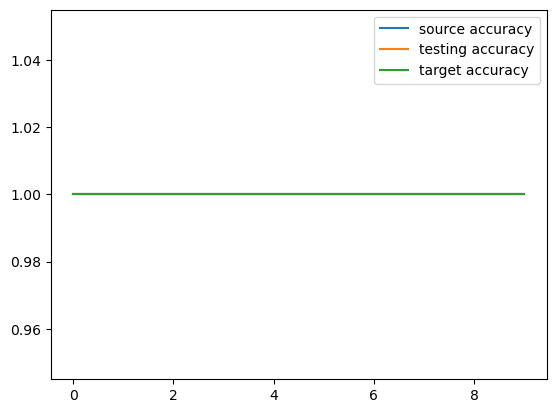

In [20]:
#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.plot(x_axis, da_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()